# Deep learning from scratch: homework 4

### General instructions

Complete the exercises listed below in this Jupyter notebook - leaving all of your code in Python cells in the notebook itself.  Feel free to add any necessary cells.  

Included with the notebook are 

- a custom utilities file called `hidden_sequence_plotter.py` that provides various plotting functionalities (for unit tests to help you debug) as well as some other processing code


- datasets for exercises: `normalized_apple_prices.csv`, `binary_switch_clipped.csv`, and `heater_clipped.csv`


be sure you have these files located in the same directory where you put this notebook to work!

### When submitting this homework:
    
**Make sure all output is present in your notebook prior to submission**

In [2]:
#### some helpful imports ####
# import autograd functionality
import autograd.numpy as np
from autograd.util import flatten_func
from autograd import grad as compute_grad   

# import custom utilities and plotter
import hidden_sequence_plotter as plotter

# import various other libraries e.g., for plotting, deep copying
import copy
import matplotlib.pyplot as plt
from matplotlib import gridspec

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook

#### <span style="color:#a50e3e;">Exercise 1. </span>  The simplest recursive model (just read!, nothing to turn in)

As discussed in class, the most basic sort of recursive model we could assume for a single input sequence $\left\{s_t\right\}_{t=1}^{P}$ is a strict recursion.  That is: every element (past a certain number of initial *seed* values) can be related to its predecessor(s) via a *recurrence relation* like

\begin{equation}
\
s_1 = \gamma \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,  \\
s_t = g\left(s_{t-1}\right).
\end{equation}

Here the recurrence relation is *order* 1, since the mathematical relationship requires only one element in the past, and the sequence has one pre-set seed value $s_1 = \gamma$.  

A general order *K* recurrence requires the prior $K$ elements of a sequence to produce the element $K+1$, and has the first $K$ seed elements likewise fixed as 

\begin{equation}
\
s_1 = \gamma_1,\,\,\,s_2 = \gamma_2,...,s_K = \gamma_K \\
s_t = g\left(s_{t-1},s_{t-2},...,s_{t-K}\right).
\end{equation}

Strict recursions like this are fairly inflexible and - as we discussed in class - can rarely be reverse engineered directly (the few instances that can be are called *differential equations* / *dynamical systems*).  That is, given a set of data and a desired relationship like the one above rarely can we determine a proper form for $g$ should via e.g., classical mathematical reasoning.  

Instead with RNNs - as is always the case when we take a machine learning approach - we don't try to determine a proper $g$ via our own reasoning, we use a flexible parameterized function (like e.g., a feedforward network) $g$ and *tune* its parameters so that the above relation holds as well as possible for a given dataset.  Of course to do this we have to setup an appropriate cost function, worry about the right choice of parameterized function $g$, fuss around with optimization tricks, etc., but in the end it is a much more effective and more broadly applicable problem solving approach.

When we do this with the simple recursive model above - say with one with order $K = 1$ - note how we setup the problem.  We do *not* have a perfect recursion $s_t = g\left(s_{t-1}\right)$ - thats what we are trying to learn (!): indeed the value $\hat{s}_t = g\left(s_{t-1}\right)$ is our *approximation* to the true value $s_t$ for any given setting of $g$'s internal parameters.  In other words, we could express what we really have at the start as the following adjusted set of equations

\begin{equation}
\
s_1 = \gamma \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,  \\
\hat{s}_t = g\left(s_{t-1}\right).
\end{equation}

and our goal is tune $g$ so that

\begin{equation}
\hat{s}_t \approx s_t.
\end{equation}

Now if the sequence is continuous we can do this by minimizing the Least Sqwuares cost

\begin{equation}
\sum_{t=1}^{P}\left(\hat{s}_t - s_t\right)^2 = \sum_{t=1}^{P}\left(g\left(s_{t-1}\right) - s_t\right)^2
\end{equation}

This is a perfectly fine way to get at a primitive kind of recursive modeling - and as mentioned in class it is often used e.g., for financial [time series prediction](http://www.reed.edu/economics/parker/312/tschapters/S13_Ch_1.pdf).  

One problem here from our perspective is that unless we severely overfit to a sequence using e.g., a very deep network or a flexible kernel we will never have perfect equality in equation (4), i.e., we will never have that $\hat{s}_t = s_t$, and thus our approximator $\hat{s}_t$ is not recursive as we desire it to be. 

#### <span style="color:#a50e3e;">Exercise 2. </span>  The next most complicated model of recursivity: hidden recurrence

Since the simplest form of recursive modeling does not leave us with a recursive model for our ordered sequence, we move one step up the ladder in terms of complication with our modeling.  Instead of supposing that the sequence is strictly recursive in itself, we examine another sequence $\left\{h_t\right\}_{t=1}^{P}$ (called a *hidden sequence*) that is recursive in it.  This modeling concept is often referred to as a *hidden recurrence relation*, the basic example of which takes the form

\begin{equation}
\
h_1 = \gamma \,\,\,\,\,\,\,\,\,\, \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,  \\
h_t = g\left(h_{t-1},s_{t-1}\right).
\end{equation}

As with the sequence $\left\{s_t\right\}_{t=1}^{P}$, here the first element of the hidden sequence (its *seed*) is set to a fixed value $h_1 = \gamma$ (often this is set to $s_1$).  

Note here - unlike the previous case - the *hidden* sequence is always recursive in both itself and our sequence of interest *regardless of the form of $g$ or its parameter settings* (the sequence $\left\{s_t\right\}_{t=1}^{P}$ we will approximate is sometimes referred to as the *driver* of this *hidden* sequence).  Therefore if we use it to approximate our input sequence our approximator is by definition recursive.  In other words, this means that when we take the machine learning approach to things - that is we take a parameterized function $g$, tune its parameters, etc., - and we look to tune $g$ so as to make $h_t$ approximate $s_t$ i.e.,

\begin{equation}
h_t = \hat{s}_t \approx s_t
\end{equation}

as closely as possible by minimizing an appropriate cost function, regardless of how well we tune $g$ our approximating sequence $h_t = \hat{s}_t$ is always recursive since *by definition* $h_t = g\left(h_{t-1},s_{t-1}\right)$.  In short: by using a slightly more complicated recursive model we get what we want when we switch into 'machine learning mode': a recursive approximation to our ordered sequence (this is referred to as a *simple RNN*).

However before jumping into architectures, parameter tuning, and the like lets first get comfortable with defining hidden recursive sequences in ``Python`` - using a fixed function $g$ and driven by the input sequence below.

In [3]:
# load in driver
s = np.loadtxt('normalized_apple_prices.csv')[:,np.newaxis]

Lets take a look - the series is plotted by the next cell.

<IPython.core.display.Javascript object>


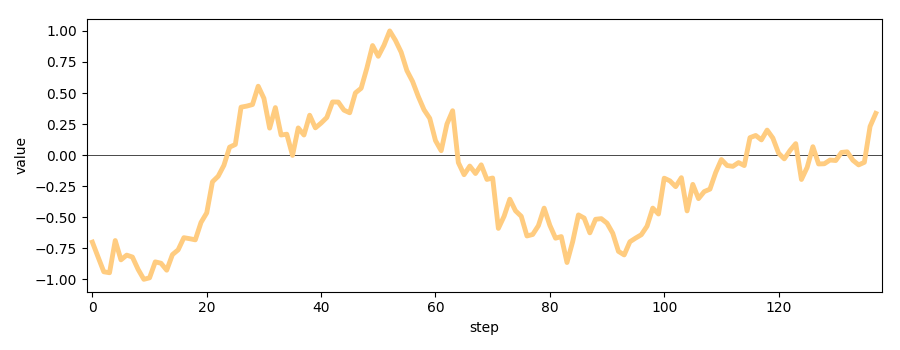

In [4]:
# plot the driving sequence 's' and the hidden sequence 'h'
plot_demo = plotter.Visualizer()          
plot_demo.show_sequences(seq1 = s,seq2 = [])

Next lets drive an order $K = 1$ hidden sequence assuming the following seed value and function $g$

\begin{equation}
\
h_1 = s_1 \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \\
h_t = \text{tanh}\left(h_{t-1} + s_{t-1}\right).
\end{equation}

In ``Python`` we can write the function $g$ here as 

In [5]:
### produce next number in sequence
def g(h_t1,s_t1):
    h_t =  np.tanh(np.sum(h_t1) + np.sum(s_t1))
    return h_t

Now, lets take our input sequence and have it **drive** the hidden sequence $\left \{h_t \right\}_{t=1}^{P}$  We define a short ``Python`` function below that takes in a sequence ``s`` and drives a hidden sequence ``h`` using any a pre-defined seed value and function ``g``.

In [6]:
def drive_hidden_sequence(s):
    '''
    use an input sequence 's' to drive a hidden sequence 'h' of order 1
    '''
    # set first seed value of hidden sequence to first seed value of actual sequence
    h = [s[0]]
    
    # initialize the previous hidden state value h_t to seed, and loop over s to construct the remainder of h
    h_t = np.asarray(h)
    for t in range(len(s)-1):
        # prepare s_t to update hidden sequence element (h_t is already prepared)
        s_t = s[t:t+1]
        
        # run through recursion function g 
        h_t_plus_1 = g(h_t,s_t)

        # update array of previous hidden state values with recently computed value
        h_t = h_t[1:]
        h_t = np.vstack([h_t,h_t_plus_1])
        
        # store current approximation to s
        h.append(h_t_plus_1)
    
    return np.asarray(h)

Lets create the hidden sequence using this module and our input sequence, and then plot both together.  Already we can see that - even with a carelessly chosen function $g$ that our hidden sequence resembles its driver somewhat (certainly giving us hope that when we use a parameterized $g$ we can really make a close approximation).

<IPython.core.display.Javascript object>


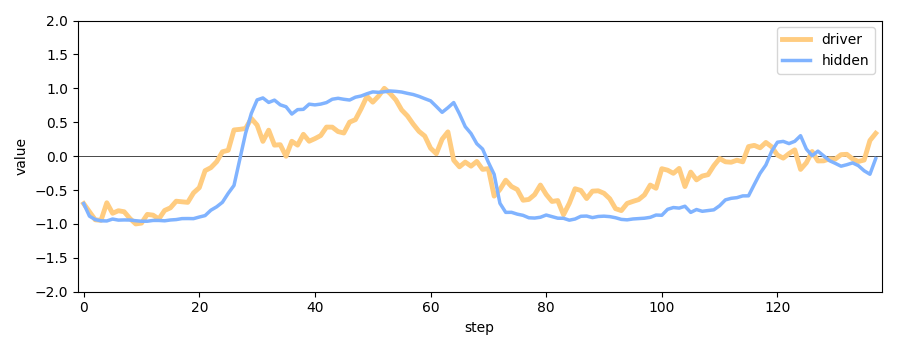

In [7]:
# drive a hidden sequence based on the 's'
h = drive_hidden_sequence(s)

# plot the driving sequence 's' and the hidden sequence 'h'
plot_demo = plotter.Visualizer()           # small plotting tool
plot_demo.show_sequences(seq1 = s,seq2 = h,labels = ['driver','hidden'])

## TO DO:

Now that you have examined the code to produce an order $K=1$ hidden sequence, extend the code block ``drive_hidden_sequence`` to produce hidden sequences of arbitrary order $K$.  Mathematically these look like

\begin{equation}
\
h_1 = \gamma_1,\,\,\,h_2 = \gamma_2,...,h_K = \gamma_K \\
h_t = g\left(h_{t-1},h_{t-2},...,h_{t-K},s_{t-1},s_{t-2},...,s_{t-K}\right) 
\end{equation}

where the first $K$ values are fixed at seed values.

In your adjustment you can set the first $K$ seed values of the hidden sequence to the first $K$ elements of the driver ``s``, in other words you will implement the following explicit hidden sequence


\begin{equation}
\
h_1 = s_1,\,\,\,h_2 = s_2,...,h_K = s_K \\
h_t = \text{tanh}\left(h_{t-1} + h_{t-2} + ... + h_{t-K} + s_{t-1} + s_{t-2} + ... + s_{t-K}\right) 
\end{equation}

You can check that your code is working properly via the two unit tests below: the first shows the result of using an order $K = 3$ recursion, and the second an order $K = 80$.

In [8]:
### produce next number in sequence
def g(h_t1,s_t1):
    h_t =  np.tanh(np.sum(h_t1) + np.sum(s_t1))
    return h_t

def drive_hidden_sequence_order(s,order=1):
    '''
    use an input sequence 's' to drive a hidden sequence 'h' of order 1
    '''
    # set first seed value of hidden sequence to first seed value of actual sequence
    h = s[0:order-1]
    
    # initialize the previous hidden state value h_t to seed, and loop over s to construct the remainder of h
    h_t = np.asarray(h)
    for t in range(len(s)-order):
        # prepare s_t to update hidden sequence element (h_t is already prepared)
        s_t = s[t:t+order]
        
        # run through recursion function g 
        h_t_plus_1 = g(h_t,s_t)
        print(h_t.shape)
        # update array of previous hidden state values with recently computed value
        h_t = h_t[1:]
        print(h_t.shape)
        h_t = np.vstack([h_t,h_t_plus_1])
        
        # store current approximation to s
        h = np.append(h,h_t_plus_1)
    
    return np.asarray(h)

(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 1)

<IPython.core.display.Javascript object>


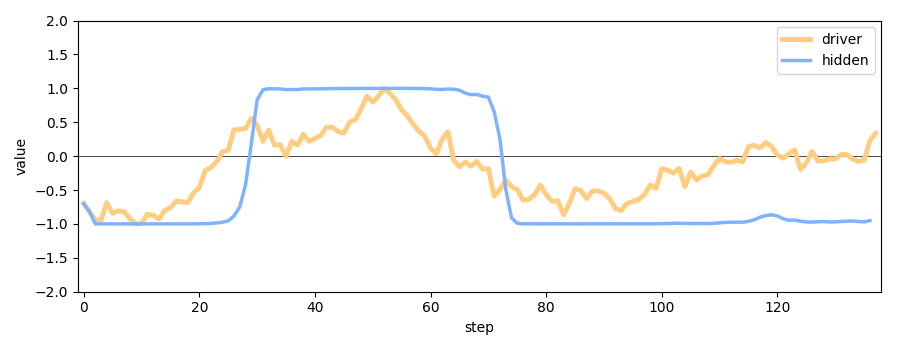

In [9]:
# drive a hidden sequence of order 3 based on the 's'
order = 3
h = drive_hidden_sequence_order(s,order)

# plot the driving sequence 's' and the hidden sequence 'h'
plot_demo = plotter.Visualizer()          
plot_demo.show_sequences(seq1 = s,seq2 = h,labels = ['driver','hidden'])

(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)
(79, 1)
(78, 1)


<IPython.core.display.Javascript object>


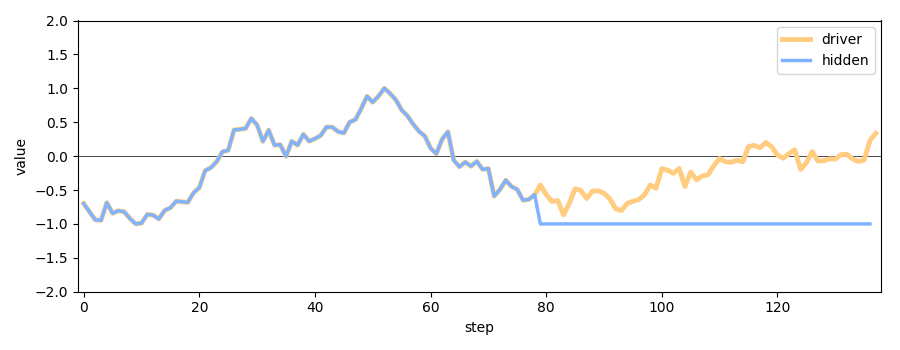

In [10]:
# drive a hidden sequence based on the 's'
order = 80
h = drive_hidden_sequence_order(s,order)

# plot the driving sequence 's' and the hidden sequence 'h'
plot_demo = plotter.Visualizer()           # small plotting tool
plot_demo.show_sequences(seq1 = s,seq2 = h,labels = ['driver','hidden'])

#### <span style="color:#a50e3e;">Exercise 3. </span>  Now lets learn the parameters of a hidden recursion: the simple RNN

Now lets use a parameterized recursion $g$ and tune its parameters so that the hidden sequence approximates an input driver as well as possible.  As discussed above, now we will learn a proper form of $g$ in equations (6) or (9) (depending on the order of recursion we choose) so that

\begin{equation}
h_t = \hat{s}_t \approx s_t
\end{equation}

over all $t=1,...,P$.  To try this out we will use the continuous sequence introduced in the previous exercise, so we can force the approximations above to hold as tightly as possible by minimizing the Least Squares error

\begin{equation}
\sum_{t=1}^{P}\left(h_t - s_t\right)^2 = \sum_{t=1}^{P}\left(g\left(h_{t-1},s_{t-1}\right) - s_t\right)^2
\end{equation}

In terms of our ``predict`` notation this means

\begin{equation}
\text{predict}\left(s_1,s_2,...,s_t,\omega\right) = h_t
\end{equation}

and so we can re-purpose our ``drive_hidden_sequence`` module above, now it should take in the parameters $\omega$ of our recursion $g$ as well and we will shove it through a Least Squares cost function.

## TO DO

Re-purpose the ``drive_hidden_sequence`` module you created in the previous exercise - the version that allows you to produce hidden sequences of order $K$ - and turn it into a proper ``predict`` function (there is very little to do here if you have completed the previous exercise properly!) so that you can learn general order $K$ hidden sequence approximations.  For the function $g$, just use a simple linear combination as defined in the next ``Python`` cell.  Notice this function takes in a set of parameters!

In [80]:
# run through recursion function g - here just linear combination of input
def g(h,s,omega):
    h_t = omega[0] + np.dot(h.T,omega[1]) + np.dot(s.T,omega[2])
    return h_t

Below is a compact ``least_squares`` function you can use as well.

In [12]:
# a least squares cost function for our ``predict``
least_squares = lambda omega: np.sum((predict(s,omega,order) - s)**2)

Show that your implementation works correctly by learning a $K = 1$ and $K = 50$ order hidden sequence approximator, we show images of our final learned approximators in each case below.

To produce the results shown below we used

- 100 steps of unnormalized gradient descent with a steplength parameter $\alpha = 10^{-3}$

- a small random initialization for all the weights

Your results do not need to look exactly like these (given your choice of initialization, number of steps of gradient descent, etc,. there will be differences), but they should roughly resemble them.

The result of our $K=1$ order approximator.

In [65]:

def predict(s,omega,order=1):
    '''
    use an input sequence 's' to drive a hidden sequence 'h' of order 1
    '''
    # set first seed value of hidden sequence to first seed value of actual sequence
    h=list(s[0:order])
    
    # initialize the previous hidden state value h_t to seed, and loop over s to construct the remainder of h
    h_t = np.asarray(h)
    for t in range(len(s)-order):
        # prepare s_t to update hidden sequence element (h_t is already prepared)
        s_t = s[t:t+order]
        
        # run through recursion function g 
        h_t_plus_1 = g(h_t,s_t,omega)
        # update array of previous hidden state values with recently computed value
        h_t = h_t[1:]
        h_t = np.vstack([h_t,h_t_plus_1])
        
        # store current approximation to s
        h.append(h_t_plus_1)
    
    return np.asarray(h)

In [107]:
# gradient descent function
def gradient_descent(g,w,alpha,max_its,beta,version):    
    # flatten the input function, create gradient based on flat function
    g_flat, unflatten, w = flatten_func(g, w)
    grad = compute_grad(g_flat)

    # record history
    w_hist = []
    w_hist.append(unflatten(w))

    # start gradient descent loop
    z = np.zeros((np.shape(w)))      # momentum term
    
    # over the line
    for k in range(max_its):   
        # plug in value into func and derivative
        grad_eval = grad(w)
        grad_eval.shape = np.shape(w)

        ### normalized or unnormalized descent step? ###
        if version == 'normalized':
            grad_norm = np.linalg.norm(grad_eval)
            if grad_norm == 0:
                grad_norm += 10**-6*np.sign(2*np.random.rand(1) - 1)
            grad_eval /= grad_norm
            
        # take descent step with momentum
        z = beta*z + grad_eval
        w = w - alpha*z

        # record weight update
        w_hist.append(unflatten(w))

    return w_hist

[[-0.70062339]
 [-0.66979047]
 [-0.8108971 ]
 [-0.92039054]
 [-0.91031402]
 [-0.61924713]
 [-0.8448689 ]
 [-0.76315909]
 [-0.79446791]
 [-0.9015955 ]
 [-0.97321112]
 [-0.94748609]
 [-0.80678657]
 [-0.84345274]
 [-0.9003647 ]
 [-0.74892981]
 [-0.73176821]
 [-0.62419428]
 [-0.65165235]
 [-0.65742563]
 [-0.49825556]
 [-0.43869498]
 [-0.16645122]
 [-0.16289446]
 [-0.06444171]
 [ 0.0841181 ]
 [ 0.08296367]
 [ 0.42223739]
 [ 0.37353537]
 [ 0.39593084]
 [ 0.558898  ]
 [ 0.42049696]
 [ 0.17350683]
 [ 0.40272513]
 [ 0.11402628]
 [ 0.17110995]
 [-0.03143221]
 [ 0.25335758]
 [ 0.13975972]
 [ 0.33933733]
 [ 0.1898919 ]
 [ 0.25916463]
 [ 0.29823932]
 [ 0.43272527]
 [ 0.40831998]
 [ 0.33892888]
 [ 0.32699324]
 [ 0.51008617]
 [ 0.5204203 ]
 [ 0.70139284]
 [ 0.87603449]
 [ 0.74825439]
 [ 0.87111923]
 [ 0.97970473]
 [ 0.87525042]
 [ 0.78546157]
 [ 0.63424256]
 [ 0.5605431 ]
 [ 0.43641543]
 [ 0.33738413]
 [ 0.27645636]
 [ 0.08532036]
 [ 0.02598121]
 [ 0.2777925 ]
 [ 0.35626798]
 [-0.1285516 ]
 [-0.15535

<IPython.core.display.Javascript object>


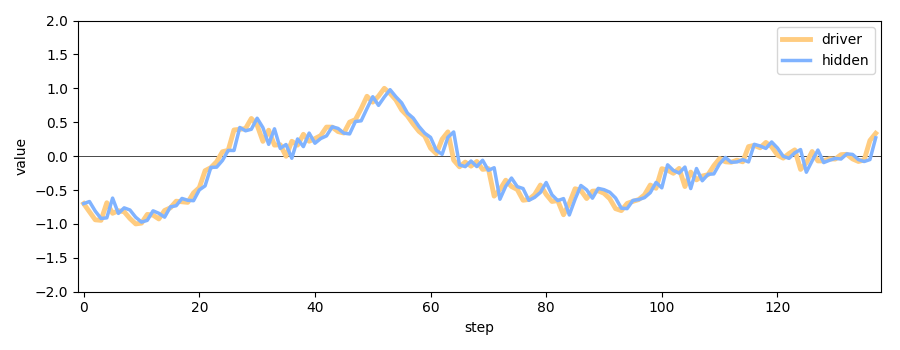

In [115]:
order = 1
o1 = np.random.random((1,1))
o2 = np.random.random((order,1))
o3 = np.random.random((order,1))
omega = [o1,o2,o3]

alpha = 10**-3
max_iter = 100
beta = 0; 
weight_history = gradient_descent(g = least_squares,alpha = alpha, max_its = max_iter, w = omega, beta = beta, version = "unnormalized")
w1 = weight_history[-1]
h = predict(s,w1,order)
print(h)

# plot the driving sequence 's' and the hidden sequence 'h'
plot_demo = plotter.Visualizer()           # small plotting tool
plot_demo.show_sequences(seq1 = s,seq2 = h,labels = ['driver','hidden'])

An order $K=50$ model.

<IPython.core.display.Javascript object>


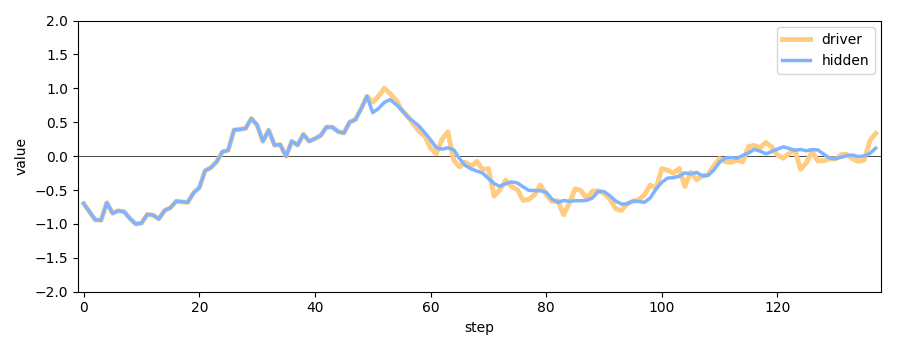

In [122]:
order = 50
o1 = np.random.random((1,1))*10**-2
o2 = np.random.random((order,1))*10**-2
o3 = np.random.random((order,1))*10**-2
omega = [o1,o2,o3]

alpha = 10**-3
max_iter = 100
weight_history = gradient_descent(g = least_squares,alpha = alpha, max_its = max_iter, w = omega,beta = beta, version = "unnormalized")
w2 = weight_history[-1]
h = predict(s,w2,order)

# plot the driving sequence 's' and the hidden sequence 'h'
plot_demo = plotter.Visualizer()           # small plotting tool
plot_demo.show_sequences(seq1 = s,seq2 = h,labels = ['driver','hidden'])

#### <span style="color:#a50e3e;">Exercise 4. </span>  Tune an input-output (or 'many-to-many') simple RNN

In class we saw how to perform supervised learning - where both our input and output are ordered sequences - in two ways.  Here we will denote our input sequence as $\left\{x_t\right\}_{t=1}^{P}$ and output sequence as $\left\{y_t\right\}_{t=1}^{P}$.  In the first approach we saw, we use a hidden recursion to model our input sequence and then learn a correspondence between each individual set of input/output sequence pairs $\left(x_1,y_1\right)$, $\left(x_2,y_2\right)$, etc., all the way up to $\left(x_P,y_P\right)$ (this version requires that the two sequences have the same length).  

The mathematical model for learning this correspondence is the natural extension of the hidden sequence model we have explored in the previous exercises, and is the classic form of a *dynamical system*.  We use a parameterized hidden sequence to model our input as

\begin{equation}
\
h_t = g\left(h_{t-1},x_{t-1}\right)
\end{equation}

and another parameterized function $f$ to approximate each $y_t$ as 

\begin{equation}
y_t \approx \hat{y}_t = f\left(h_t,x_t\right).
\end{equation}

This is often written all together (with equalities on each line) as 

\begin{equation}
\
h_t = g\left(h_{t-1},x_{t-1}\right) \\
\hat{y}_t = f\left(h_t,x_t\right) 
\end{equation}

The order $K$ version is written similarly as

\begin{equation}
\
h_t = g\left(h_{t-1},h_{t-2},...,h_{t-K},x_{t-1},x_{t-2},...,x_{t-K}\right) \\ 
\,\hat{y}_t = f\left(h_t,h_{t-1},...,h_{t-K-1},x_t,x_{t-1},...,x_{t-K-1}\right)
\end{equation}

In any case, to properly tune the parameters of both $g$ and $f$ we form a Least Squares cost function corresponding to the desired approximation above, e.g., in the order 1 case

\begin{equation}
\sum_{t=1}^{P}\left(\hat{y}_t - y_t\right)^2
 = \sum_{t=1}^{P}\left(f\left(h_t,x_t\right) - y_t\right)^2.
\end{equation}

In this exercise you will extend the ``predict`` function defined in the previous exercise to deal with this supervised learning scenario.  To test your function you will use the ``hairdryer`` dataset loaded in and plotted below.

Here the input sequence (top panel) $\left\{x_t\right\}_{t=1}^{100}$ is binary, and corresponds to 100 consecutive time instances measuring whether or not a hair dryer is turned on (the larger value) or off (the lower value).  The corresponding output sequence (bottom panel) $\left\{y_t\right\}_{t=1}^{100}$ shows simultaneous temperature measurements of the heating coil of this apparatus (note: both sequences have been normalized hence e.g., the negative temperature values).  

Note the complex correspondence between input and output here, for example


- the input is binary while the output is continuous


- the effect of switching the dryer off does not immediately cool the device (likewise, turning the switch on does not immediately heat up the device)


- when the temperature of the coil reaches a maximum allowable level (set either by nature or manufacture) current through the coil drops, and the temperature decreases (this is noticeable at e.g., the beginning of these measurements) 

Using a hidden sequence helps us learn this complex relationship.

In [123]:
# load in driver
x = np.loadtxt('binary_switch_clipped.csv')[:,np.newaxis]
y = np.loadtxt('heater_clipped.csv')[:,np.newaxis]

<IPython.core.display.Javascript object>


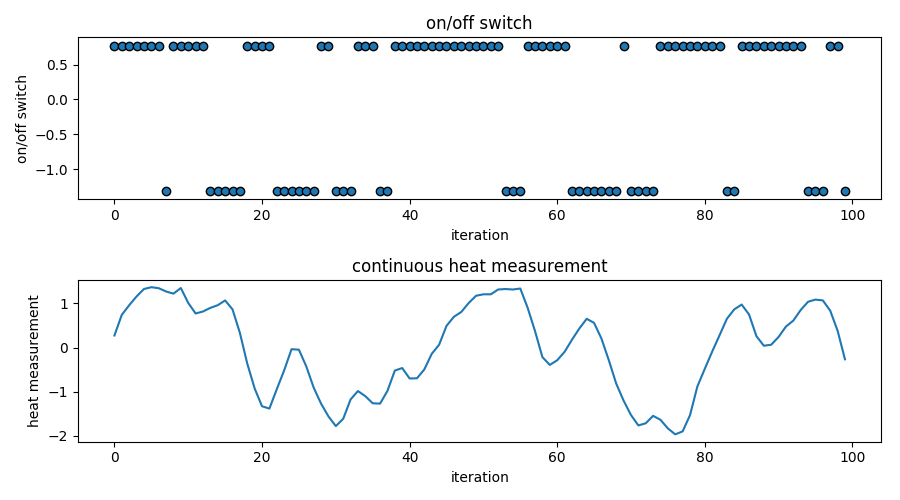

In [124]:
# plot the test pair
plot_demo = plotter.Visualizer()           
plot_demo.plot_pair(x,y)

## TODO:

Adjust the code you developed in the previous exercise - including the ``predict`` module and the ``least_squares`` function - to make accurate predictions of the output sequence above based on its corresponding input.  In other words, so that you learn the parameters of $f$ and $g$ by minimizing the Least Squares cost in equation (18) for the dataset provided above.  Use linear activations for both $g$ and $f$ - you can re-use the ``Python`` implementation for $g$ given in the previous exercise, and tweak it slightly to make a similar implementation for $f$.

Show that your code is operating correctly by producing an order $K = 1$ and $K = 10$ approximation.  Examples of both approximations are shown below - your versions should look similar to these, but they need not look identical (given your choice of initialization, steplength parameter $\alpha$, etc.,).  

To produce the resulst shown below we used

- 50 steps of normalized gradient descent with a steplength parameter $\alpha = 10^{-1}$

- a small random initialization for all the weights

Order $K=1$ approximation is below.

In [125]:
def predict(s,omega):
    '''
    use an input sequence 's' to drive a hidden sequence 'h' of order 1
    '''
    # set first seed value of hidden sequence to first seed value of actual sequence
    h = list(s[:order])
    
    # initialize the previous hidden state value h_t to seed, and loop over s to construct the remainder of h
    h_t = np.asarray(h)

    for t in range(len(s)-order):
        # prepare s_t to update hidden sequence element (h_t is already prepared)
        s_t = s[t:t+order]
        
        # run through recursion function g 
        h_t_plus_1 = g(h_t,s_t,omega[0])
        
        # update array of previous hidden state values with recently computed value
        h_t = h_t[1:]
        h_t = np.vstack([h_t,h_t_plus_1])
        
        # store current approximation to s
        y_t_plus_1 = f(h_t,s[t+1:t+order+1],omega[1])
        h.append(y_t_plus_1)
    
    return np.asarray(h)

# run through recursion function g - here just linear combination of input
def g(h,s,omega):
    h_t = omega[0] + np.dot(h.T,omega[1]) + np.dot(s.T,omega[2])
    return h_t

def f(h,s,omega):
    h_t = omega[0] + np.dot(h.T,omega[1]) + np.dot(s.T,omega[2])
    return h_t

# a least squares cost function for our ``predict``
least_squares = lambda omega: np.sum((predict(x,omega) - y)**2)

order = 1
alpha = 10**(-1)
max_its = 50
sc = 1
w_init = [[sc*np.random.rand(1,1),sc*np.random.rand(order,1),sc*np.random.rand(order,1)],[sc*np.random.rand(1,1),sc*np.random.rand(order,1),sc*np.random.rand(order,1)]]

# run gradient descent
weight_history_1 = gradient_descent(least_squares,w_init,alpha,max_its,beta = 0,version = 'normalized')

# plot cost function history
cost_history_1 = [least_squares(v) for v in weight_history_1]

<IPython.core.display.Javascript object>


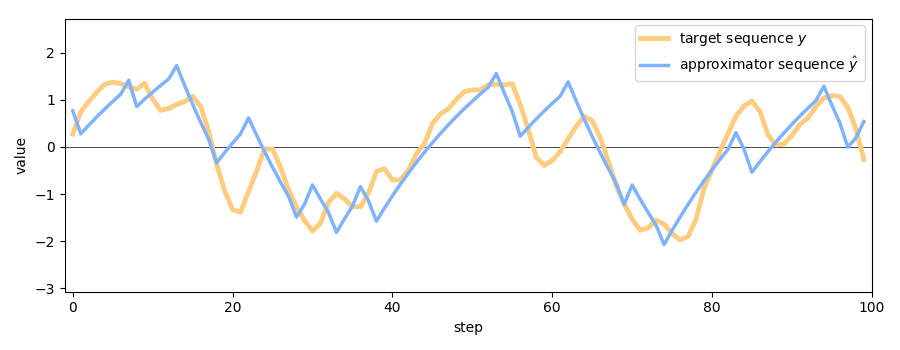

In [126]:
# make predictor y_hat
ind_best = np.argmin(cost_history_1)
w1 = weight_history_1[ind_best]
y_hat = predict(x,w1)

# plot both the target and approximating sequences 
plot_demo = plotter.Visualizer()           # small plotting tool
plot_demo.show_sequences(seq1 = y,seq2 = y_hat,labels = ['target sequence ' + r'$y$','approximator sequence ' + r'$\hat{y}$'])

Order $K=10$ approximation.

In [127]:
order = 10
alpha = 10**(-1)
max_its = 50
sc = 1e-1
w_init = [[sc*np.random.rand(1,1),sc*np.random.rand(order,1),sc*np.random.rand(order,1)],[sc*np.random.rand(1,1),sc*np.random.rand(order,1),sc*np.random.rand(order,1)]]

# run gradient descent
weight_history_1 = gradient_descent(least_squares,w_init,alpha,max_its,beta = 0,version = 'normalized')

# plot cost function history
cost_history_1 = [least_squares(v) for v in weight_history_1]

<IPython.core.display.Javascript object>


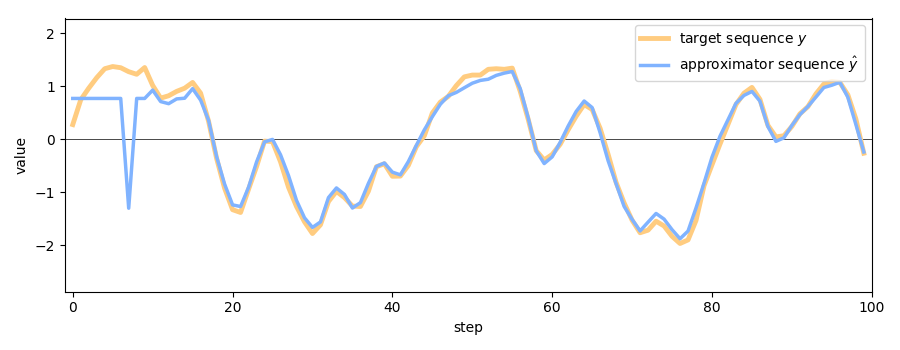

In [128]:
# make predictor y_hat
ind_best = np.argmin(cost_history_1)
w1 = weight_history_1[ind_best]
y_hat = predict(x,w1)

# plot both the target and approximating sequences 
plot_demo = plotter.Visualizer()           # small plotting tool
plot_demo.show_sequences(seq1 = y,seq2 = y_hat,labels = ['target sequence ' + r'$y$','approximator sequence ' + r'$\hat{y}$'])

#### <span style="color:#a50e3e;">Exercise 5. </span>  Read about the other RNN architectures (just reading, nothing to turn in)

In class we analyzed several fundamental issues related to the very nature of deep compositions of functions - e.g., issues with vanishing / exploding gradients - which can be dealt with easily enough with optimization tricks - and the quick decay of weight update information (due to the chain rule) that can lead simple RNNs to have 'short memory' (meaning that weight updates that should in theory depend on a long chain of prior events practically speaking only depend on just a few recent ones).  The only real solution to this latter problem is to *use activation functions / architectures* that do not suffer from this chain-rule created short term memory problem. 

Perhaps the simplest known architecture change that provides this benefit is the use of a simple RNN with relu activation functions, and a specifically chosen initialization - [see the paper that first proposed this idea here](https://arxiv.org/pdf/1504.00941.pdf).

A very popular but more complicated alternative specifically designed to avoid this issue is called the *Long Short Term Memory* architecture. You can find a [very cogent blog post describing its internal structure here](http://colah.github.io/posts/2015-08-Understanding-LSTMs/). 